In [2]:
%matplotlib inline
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
import tensorflow as tf
from sklearn import feature_extraction
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import backend as K

In [3]:
if 'session' in locals() and session is not None:
    print('Close interactive session')
    session.close()

# Network: Slice patches (2D->2D)

In [4]:
def get_data(filename):
    img = nib.load(filename)
    return img.get_data()
def scale(array):
    return (array-np.min(array))/(np.max(array) - np.min(array))
mri_data = scale(get_data('case_001_2.nii.gz'))
labelled_data = get_data('tumor.nii.gz')

In [5]:
# https://github.com/jocicmarko/ultrasound-nerve-segmentation/blob/master/train.py#L19
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [6]:
slice_size = (20,20)

In [96]:
from keras.layers import Input,Flatten, Reshape
from keras.optimizers import SGD
model = Sequential()
model.add(Dense(slice_size[1],input_shape=slice_size))
model.add(Flatten())
model.add(Dense(3))
model.add(Activation('relu'))
model.add(Dense(slice_size[0]*slice_size[1], activation='sigmoid'))
model.add(Reshape(slice_size))
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd,
              loss=dice_coef_loss, metrics=[dice_coef,'accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 20, 20)            420       
_________________________________________________________________
flatten_5 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 1203      
_________________________________________________________________
activation_5 (Activation)    (None, 3)                 0         
_________________________________________________________________
dense_15 (Dense)             (None, 400)               1600      
_________________________________________________________________
reshape_5 (Reshape)          (None, 20, 20)            0         
Total params: 3,223
Trainable params: 3,223
Non-trainable params: 0
_________________________________________________________________


In [75]:
def train_on_slice(model, slice_num, slice_size,epochs=5, initial_epoch=0, empty_patches_dropout=0):
    
    img = mri_data[:,:,slice_num]
    labels = labelled_data[:,:,slice_num]
    if empty_patches_dropout == 1:
        sum_by_row = labels.sum(axis=1)
        first_row = np.argmax(sum_by_row>0)-int(slice_size[0]/2)
        last_row = sum_by_row.size - np.argmax(sum_by_row[::-1]>0)+int(slice_size[0]/2)

        sum_by_col = labels.sum(axis=0)
        first_col = np.argmax(sum_by_col>0)-int(slice_size[1]/2)
        last_col = sum_by_col.size - np.argmax(sum_by_col[::-1]>0)+int(slice_size[1]/2)
        img = img[first_row:last_row,first_col:last_col]
        labels = labels[first_row:last_row,first_col:last_col]
    temp = np.zeros((img.shape[0], img.shape[1],2))
    temp[:,:,0] = img
    temp[:,:,1] = labels
    all_patches = feature_extraction.image.extract_patches_2d(temp, slice_size)
    print(all_patches.shape)
    patches = all_patches[:,:,:,0]
    patches_output = all_patches[:,:,:,1]#feature_extraction.image.extract_patches_2d(labelled_data[:,:,slice_num], slice_size)
    if empty_patches_dropout >0: 
        sums = patches_output.sum(axis=(1,2))
        xtrain = patches[np.where(sums>0)]
        ytrain = patches_output[np.where(sums>0)]
        if empty_patches_dropout < 1:
            sums0 = np.where(sums==0)[0]
            rand = np.random.choice(np.array(sums0),int(sums0.size*.1))
            xtrain = np.append(xtrain, patches[rand])
            ytrain = np.append(ytrain, patches[rand])
    else:
        xtrain = patches
        ytrain = patches_output        
    
    model.fit(patches,patches_output,epochs=initial_epoch+epochs, initial_epoch=initial_epoch, batch_size=5)

In [97]:
skip_empty_slices = True
empty_patches_dropout = 1  # dropout=1 means no empty/nontumor patches are kept, dropout=0 means all patches are kept
single_slice = True
epochs = 5
total_epochs = 0
for i in range(0, mri_data.shape[2]):
    if single_slice and i!=25: continue
    if skip_empty_slices:
        if np.sum(labelled_data[:,:,i]) == 0: continue
    print("training on slice",i)
    train_on_slice(model, i, slice_size, initial_epoch=total_epochs, epochs=epochs, empty_patches_dropout=empty_patches_dropout)
    total_epochs += epochs

training on slice 25
(4554, 20, 20, 2)
Epoch 1/5
4554/4554 [==============================] - 3s - loss: -0.7968 - dice_coef: 0.7968 - acc: 0.0605      

In [40]:
model.save('some_nontumor_patches.h4')

In [10]:
model.load_weights('model_patches_tumor_patches_only.h4')

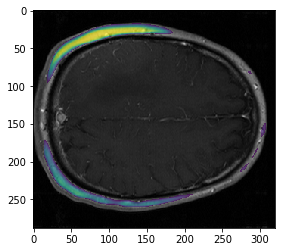

In [102]:
# Predicting on same data returns mostly zeros with blank data
predict_num = 21
patches = feature_extraction.image.extract_patches_2d(mri_data[:,:,predict_num], slice_size)
predict = model.predict(patches)
new_data = feature_extraction.image.reconstruct_from_patches_2d(predict,(288,320))

fig, ax = plt.subplots(1,1)
#ax.imshow(new_data)
ax.imshow(mri_data[:,:,predict_num],cmap=plt.cm.gray)
ax.imshow(np.ma.masked_where(new_data<=.5, new_data),alpha=.7)
#ax.imshow(np.ma.masked_where(labelled_data[:,:,predict_num]==0, labelled_data[:,:,predict_num]),alpha=.5,cmap=plt.cm.autumn, interpolation='none')

In [89]:
new_data.max()

0.53673504605889322

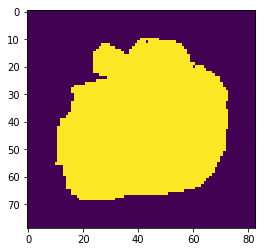

In [62]:
plt.imshow(img[first_row:last_row,first_col:last_col])

In [54]:
predict.shape

(55221, 24, 20)

In [168]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
def calc_accuracy(actual,pred):
    pred = pred.reshape(pred.size)
    actual = actual.reshape(actual.size)
    pred[pred<.5] = 0
    pred[pred>=.5] = 1
    #precision,recall,threshold = precision_recall_curve(actual, pred, 1)
    
    #return precision, recall, threshold, accuracy_score(actual,pred)
    return accuracy_score(actual,pred),precision_score(actual,pred), recall_score(actual,pred)
def print_scores(actual, pred):
    accuracy, precision, recall = calc_accuracy(actual.astype(float), pred)    
    print("Accuracy =", accuracy)
    print("Precision =", precision)
    print("Recall =", recall)

In [128]:
case = 21
mri_data2 = scale(get_data('../data/case_0%02d_2.nii.gz'%case))
labelled_data2 = get_data('../data/case_0%02d_labels.nii.gz'%case)
mri_data2.shape

(348, 384, 28)

Returning slice 14 [ 9 10 11 12 13 14 15 16 17 18]
Accuracy = 0.925422054598
Precision = 0.491481099929
Recall = 0.636037329505


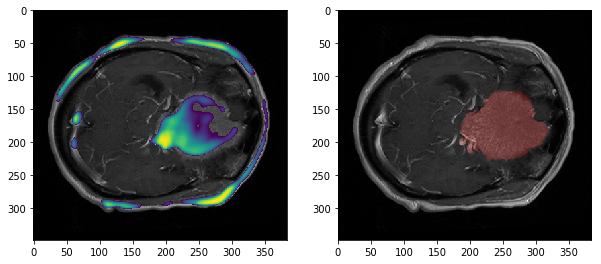

In [171]:
def get_slice():
    eh = np.where(labelled_data2.sum(axis=(0,1))>0)[0]
    print ("Returning slice",eh[int(eh.size/2)],eh)
    return eh[int(eh.size/2)]
predict_num = get_slice()
predict_num = 11
patches = feature_extraction.image.extract_patches_2d(mri_data2[:,:,predict_num], slice_size)
predict = model.predict(patches)

new_data = feature_extraction.image.reconstruct_from_patches_2d(predict,[mri_data2.shape[0],mri_data2.shape[1]])

fig, ax = plt.subplots(1,2)
fig.set_size_inches(10,10)
ax[0].imshow(mri_data2[:,:,predict_num],cmap=plt.cm.gray)
ax[0].imshow(np.ma.masked_where(new_data<.5, new_data))
ax[1].imshow(mri_data2[:,:,predict_num],cmap=plt.cm.gray)
ax[1].imshow(np.ma.masked_where(labelled_data2[:,:,predict_num]==0, labelled_data2[:,:,predict_num]),alpha=.2,cmap=plt.cm.autumn, interpolation='none')
print_scores(labelled_data2[:,:,predict_num],new_data)


In [ ]:
def predict(model, slices):
    predictions = {}
    for predict_num in slices:
        patches = feature_extraction.image.extract_patches_2d(mri_data[:,:,predict_num], slice_size)
        predict = model.predict(patches)
        predictions[predict_num] = feature_extraction.image.reconstruct_from_patches_2d(predict,(288,320))
    return predictions

# Network: Slice Patches (2D->1D)

In [35]:
def get_data(filename):
    img = nib.load(filename)
    return img.get_data()
def scale(array):
    return (array-np.min(array))/(np.max(array) - np.min(array))
mri_data = scale(get_data('case_001_2.nii.gz'))
labelled_data = get_data('tumor.nii.gz')
shape = labelled_data.shape

In [36]:
slice_num = 25
slice_size = (24,20)
patches = feature_extraction.image.extract_patches_2d(mri_data[:,:,slice_num], slice_size)
patches = np.reshape(patches, (patches.shape[0],slice_size[0]*slice_size[1]))

label_patches = feature_extraction.image.extract_patches_2d(labelled_data[:,:,slice_num], slice_size)
label_sums = np.reshape(np.sum(label_patches,axis=(1,2)), [patches.shape[0],1])
# normalize sums
label_sums /= label_sums.max()

patches_output = labelled_data[12:shape[0]-11,10:shape[1]-9,slice_num]
patches_output = np.reshape(patches_output,[patches_output.size,1])
patches_output = np.concatenate((patches_output, label_sums), axis=1)

In [37]:
model = Sequential()
model.add(Dense(30,input_dim=(slice_size[0]*slice_size[1])))
model.add(Activation('relu'))
#model.add(Dense(20,activation='relu'))
#model.add(Dense(10,activation='relu'))
model.add(Dense(2,activation='relu'))
model.compile(optimizer='rmsprop',
              loss=dice_coef_loss, metrics=[dice_coef])
model.fit(patches,patches_output)

Epoch 1/10
79765/79765 [==============================] - 3s - loss: -0.5108 - dice_coef: 0.5108     
Epoch 2/10
79765/79765 [==============================] - 3s - loss: -0.5099 - dice_coef: 0.5099     
Epoch 3/10
79765/79765 [==============================] - 3s - loss: -0.5132 - dice_coef: 0.5132     
Epoch 4/10
79765/79765 [==============================] - 3s - loss: -0.5056 - dice_coef: 0.5056     
Epoch 5/10
79765/79765 [==============================] - 3s - loss: -0.5072 - dice_coef: 0.5072     
Epoch 6/10
79765/79765 [==============================] - 3s - loss: -0.5059 - dice_coef: 0.5059     
Epoch 7/10
79765/79765 [==============================] - 3s - loss: -0.5084 - dice_coef: 0.5084     
Epoch 8/10
79765/79765 [==============================] - 3s - loss: -0.5041 - dice_coef: 0.5041     
Epoch 9/10
79765/79765 [==============================] - 3s - loss: -0.5157 - dice_coef: 0.5157     
Epoch 10/10
79765/79765 [==============================] - 3s - loss: -0.5041 - di

In [38]:
slice_num2 = 29
patches2 = feature_extraction.image.extract_patches_2d(mri_data[:,:,slice_num2], slice_size)
patches2 = np.reshape(patches, (patches.shape[0],slice_size[0]*slice_size[1]))

#patches_output2 = labelled_data[12:shape[0]-11,10:shape[1]-9,slice_num]
#patches_output2 = np.reshape(patches_output2,[patches_output.size,1])
#print '\n',model.evaluate(patches2,patches_output2)
predict = model.predict(patches2)
#new_data=predict[:,0].reshape(shape[0]-24+1, shape[1]-20+1)

In [17]:
test = feature_extraction.image.extract_patches_2d(labelled_data[:,:,slice_num2], slice_size)

In [40]:
predict[:,0].shape

(79765,)

/usr/local/lib/python2.7/dist-packages/matplotlib/colors.py:941: UserWarning: Warning: converting a masked element to nan.
  vmin = float(vmin)
/usr/local/lib/python2.7/dist-packages/matplotlib/colors.py:942: UserWarning: Warning: converting a masked element to nan.
  vmax = float(vmax)


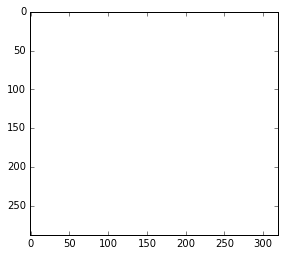

In [39]:
new_data = np.zeros(shape[:2])
new_data[12:shape[0]-11,10:shape[1]-9] = predict[:,1].reshape(shape[0]-24+1, shape[1]-20+1)
fig, ax = plt.subplots(1,1)

#ax.imshow(mri_data[:,:,slice_num2],cmap=plt.cm.gray)
#ax.imshow(np.ma.masked_where(labelled_data[:,:,slice_num2]==0, labelled_data[:,:,slice_num2]),alpha=.7,cmap=plt.cm.autumn, interpolation='none')
ax.imshow(np.ma.masked_where(new_data==0, new_data))

In [10]:
np.sum(predict[:,0])

0.0

///////////////////////////////////////

In [3]:
def scale(array):
    return (array-np.min(array))/(np.max(array) - np.min(array))

In [4]:
slice = data[100,:,:]
x,y = np.meshgrid(np.arange(slice.shape[0]),np.arange(slice.shape[1]))
x = scale(x.reshape(x.size,1))
y = scale(y.reshape(y.size,1))
slice = scale(slice.reshape(slice.size,1)) 
X = np.column_stack((x,y,slice)).astype('float32')
X.shape

In [5]:
pairwise_dists = squareform(pdist(X, 'euclidean'))
print pairwise_dists.size

s = 1.5
K = np.exp(np.square(pairwise_dists)).reshape

MemoryError: 

In [7]:
test = np.array([[1,2],[3,4]])
np.sum(test,axis=)

In [14]:
pairwise_dists

array([ 0.00569339,  0.108043  ,  0.38101912, ...,  0.        ,
        2.        ,  2.        ])

In [22]:
np.sum(labelled_data[slice_num,:,:])

3457

## References
### Diffusion Maps
https://www.stat.cmu.edu/~cshalizi/350/lectures/15/lecture-15.pdf
https://en.wikipedia.org/wiki/Diffusion_map
http://stats.stackexchange.com/questions/15798/how-to-calculate-a-gaussian-kernel-effectively-in-numpy

https://arxiv.org/pdf/1506.07840.pdf